In [259]:
# <b>CS156 (Introduction to AI), Spring 2021</b>
# <u><b>Homework 8 submission</b></u>
### Roster Name: Edmond Lin
### Preferred Name (if different): Chosen Name
### Student ID: 012290668
### Email address: edmond.lin@sjsu.edu
##  <u>Solution</u>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np

In [29]:
np.random.seed(42)

In [84]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/edmondlin/documents/cs156/Hw9/flowers/training",
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/edmondlin/documents/cs156/Hw9/flowers/training",
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/edmondlin/documents/cs156/Hw9/flowers/test",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=1,
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


In [33]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [65]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 180, 180, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 180, 180, 3)  0           sequential_2[7][0]               
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 90, 90, 32)   896         rescaling_7[0][0]                
____________________________________________________________________________________________

In [80]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 583s 6s/step - loss: 0.4473 - accuracy: 0.4843 - val_loss: 0.5831 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 745s 9s/step - loss: 0.3291 - accuracy: 0.6277 - val_loss: 0.6796 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 766s 9s/step - loss: 0.3037 - accuracy: 0.6872 - val_loss: 0.8900 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 894s 10s/step - loss: 0.2694 - accuracy: 0.7194 - val_loss: 1.0365 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 692s 8s/step - loss: 0.2574 - accuracy: 0.7317 - val_loss: 1.0461 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 833s 10s/step - loss: 0.2475 - accuracy: 0.7322 - val_loss: 0.6210 - val_accuracy: 0.3329
Epoch 7/20
87/87 [==============================] - 717s 8s/step - loss: 0.2331 - accuracy: 0.7580 - val_loss: 0.3226 - val_accuracy: 0.6512
Epoch 8/20


In [252]:
predicted_labels = []
true_labels = []
for x, y in test_ds:
        predicted = model.predict(x)
        predicted_index = np.argmax(predicted)
        true_index = np.argmax(y)
        predicted_labels.append(predicted_index)
        true_labels.append(true_index)

In [253]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

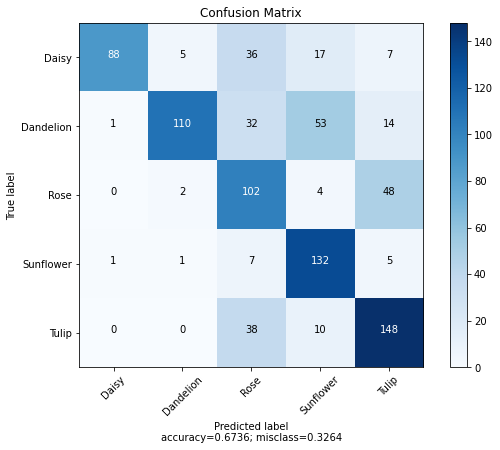

In [254]:
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()
plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"],
                      title        = "Confusion Matrix")

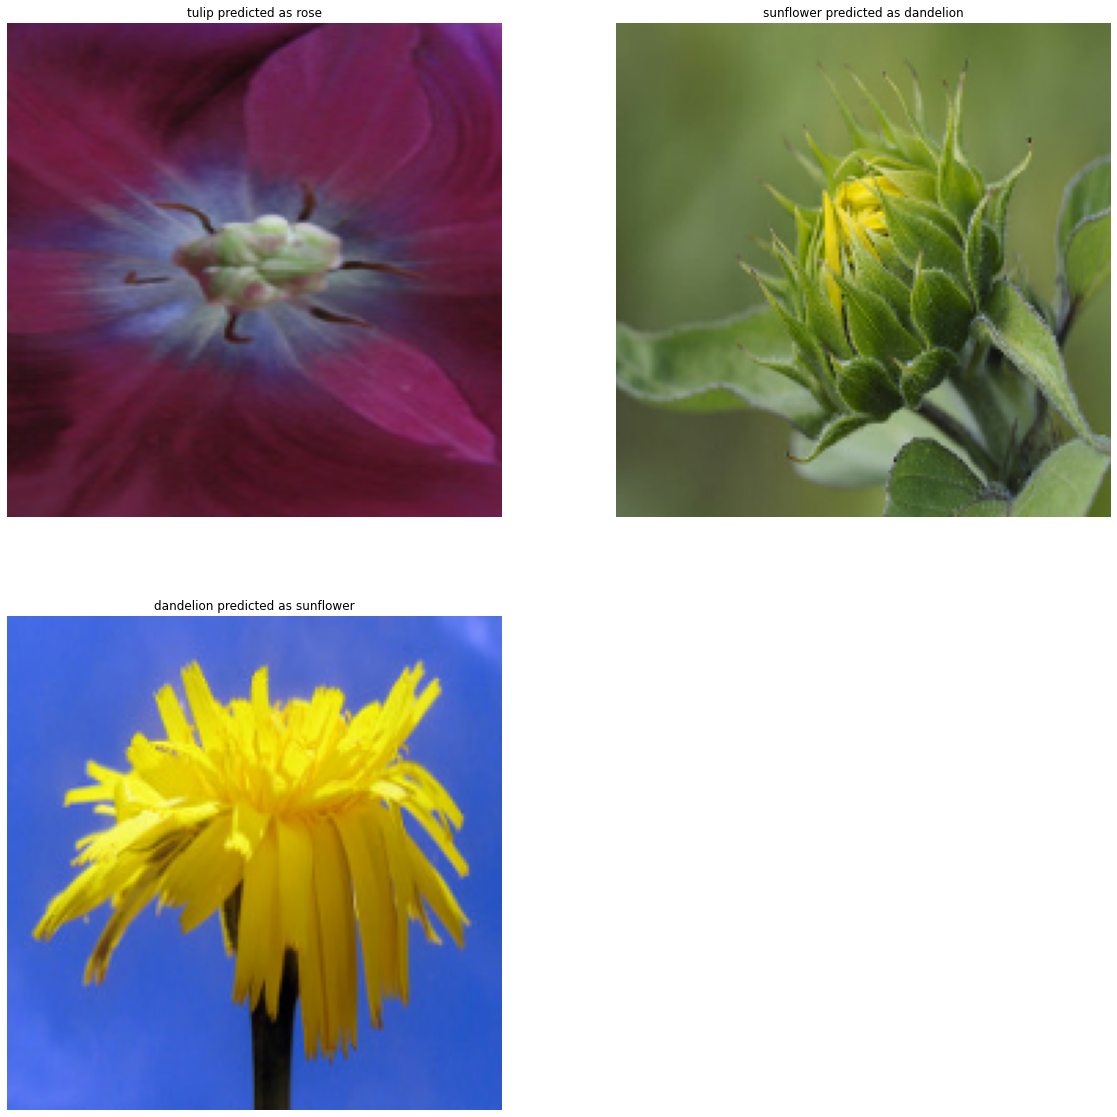

In [257]:
true_labels = []
predicted_labels = []
class_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
plt.figure(figsize=(20, 20))
count = 0
for images, labels in test_ds:
    prediction = np.argmax(model.predict(images))
    predicted_labels.append(prediction)
    true_labels.append(np.argmax(labels))
    predictions = model.predict(images)
    predicted = np.argmax(predictions)
    real = np.argmax(labels)
    if (predicted != real):
        titlething = class_names[real] + " predicted as " + class_names[predicted]
        if (count < 3):
            ax = plt.subplot(2, 2, count + 1)
            plt.imshow(images[0].numpy().astype("uint8"))
            plt.title(titlething)
        count = count + 1
        plt.axis("off")